# Question 4:

### *Does time of year (month or season) affect the amount of each category that is ordered?*

We also need to account for North/South Hemisphere & Tropical regions with no winters.

## Define Hypotheses

*    ***Null Hypothesis:*** The time of year has no impact on product sales.
*    ***Alternate Hypothesis:*** The time of year has a statistically significant impact on product sales.

For reference, the relational structure of this dataset is provided below.
<img src='Northwind_ERD.png'>

## Importing Data & Libraries

In [1]:
# For SQL & dataframes
import pandas as pd
import sqlite3

# For math & statistics
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# For graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


## Run SQL queries to examine data

In [3]:
c.execute("""
          SELECT p.ProductName, cat.CategoryName, s.Region as SupplierRegion,
          od.Quantity as Units, (od.Quantity*od.UnitPrice*(1-od.Discount)) as OrderPrice, o.OrderDate,
          o.ShipRegion as CustomerRegion, o.ShipCountry as CustomerCountry
          FROM OrderDetail od
          JOIN 'Order' o  ON od.OrderId = o.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON cat.Id = p.CategoryId
          JOIN Supplier s ON p.SupplierId = s.Id
          ORDER BY 1;
          """)

df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]

for i in ['Northern Europe','Eastern Europe','Scandinavia']:
    df.replace(i, 'Northeastern Europe', inplace=True)
for i in ['South America','Central America']:
    df.replace(i, 'Latin America', inplace=True)
for i in ['Victoria', 'NSW']:
    df.replace(i, 'Australia', inplace=True)

display(df.head())
df.info()

,ProductName,CategoryName,SupplierRegion,Units,OrderPrice,OrderDate,CustomerRegion,CustomerCountry
0,Alice Mutton,Meat/Poultry,Australia,30,936.0,2012-07-25,Western Europe,France
1,Alice Mutton,Meat/Poultry,Australia,15,351.0,2012-08-13,Western Europe,Germany
2,Alice Mutton,Meat/Poultry,Australia,15,468.0,2012-08-30,North America,USA
3,Alice Mutton,Meat/Poultry,Australia,40,1248.0,2012-09-10,Western Europe,Belgium
4,Alice Mutton,Meat/Poultry,Australia,8,249.6,2012-10-02,Latin America,Mexico


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
ProductName        2155 non-null object
CategoryName       2155 non-null object
SupplierRegion     2155 non-null object
Units              2155 non-null int64
OrderPrice         2155 non-null float64
OrderDate          2155 non-null object
CustomerRegion     2155 non-null object
CustomerCountry    2155 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 134.8+ KB


In [4]:
c.execute("""
          SELECT p.ProductName, cat.CategoryName, s.Region as SupplierRegion, o.ShipRegion as CustomerRegion,
          SUM(od.Quantity) as TotalUnits, SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) as TotalPrice
          FROM OrderDetail od
          JOIN 'Order' o  ON od.OrderId = o.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON cat.Id = p.CategoryId
          JOIN Supplier s ON p.SupplierId = s.Id
          GROUP BY 1,2,3,4
          ORDER BY 1,4;
          """)

prod_totals_df = pd.DataFrame(c.fetchall())
prod_totals_df.columns = [x[0] for x in c.description]
for i in ['Northern Europe','Eastern Europe','Scandinavia']:
    prod_totals_df.replace(i, 'Northeastern Europe', inplace=True)
for i in ['South America','Central America']:
    prod_totals_df.replace(i, 'Latin America', inplace=True)
for i in ['Victoria', 'NSW']:
    prod_totals_df.replace(i, 'Australia', inplace=True)
prod_totals_df = (prod_totals_df.groupby(['ProductName','CategoryName','SupplierRegion','CustomerRegion'])
                  .sum().reset_index())

display(prod_totals_df.head(10))
prod_totals_df.info()

,ProductName,CategoryName,SupplierRegion,CustomerRegion,TotalUnits,TotalPrice
0,Alice Mutton,Meat/Poultry,Australia,British Isles,25,877.50
1,Alice Mutton,Meat/Poultry,Australia,Latin America,63,2394.60
2,Alice Mutton,Meat/Poultry,Australia,North America,487,16281.33
3,Alice Mutton,Meat/Poultry,Australia,Northeastern Europe,10,312.00
4,Alice Mutton,Meat/Poultry,Australia,Southern Europe,80,2659.80
5,Alice Mutton,Meat/Poultry,Australia,Western Europe,313,10173.15
6,Aniseed Syrup,Condiments,British Isles,British Isles,30,240.00
7,Aniseed Syrup,Condiments,British Isles,Latin America,70,544.00
8,Aniseed Syrup,Condiments,British Isles,North America,24,240.00
9,Aniseed Syrup,Condiments,British Isles,Northeastern Europe,44,440.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 6 columns):
ProductName       426 non-null object
CategoryName      426 non-null object
SupplierRegion    426 non-null object
CustomerRegion    426 non-null object
TotalUnits        426 non-null int64
TotalPrice        426 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 20.0+ KB


In [5]:
c.execute("""
          SELECT s.Region as SupplierRegion, o.ShipRegion as CustomerRegion,
          SUM(od.Quantity) as TotalUnits, SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) as TotalPrice
          FROM OrderDetail od
          JOIN 'Order' o  ON od.OrderId = o.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON cat.Id = p.CategoryId
          JOIN Supplier s ON p.SupplierId = s.Id
          GROUP BY 1,2
          ORDER BY 1,3 desc,2;
          """)

regions_df = pd.DataFrame(c.fetchall())
regions_df.columns = [x[0] for x in c.description]
for i in ['Northern Europe','Eastern Europe','Scandinavia']:
    regions_df.replace(i, 'Northeastern Europe', inplace=True)
for i in ['South America','Central America']:
    regions_df.replace(i, 'Latin America', inplace=True)
for i in ['Victoria', 'NSW']:
    regions_df.replace(i, 'Australia', inplace=True)
regions_df = (regions_df.groupby(['SupplierRegion', 'CustomerRegion']).sum()
              .sort_values(by=['SupplierRegion','TotalUnits'], ascending=[True, False])
              .reset_index())
display(regions_df)
regions_df.info()

,SupplierRegion,CustomerRegion,TotalUnits,TotalPrice
0,Australia,Western Europe,2276,68996.6475
1,Australia,North America,1439,42389.3880
2,Australia,Latin America,1002,24650.5700
3,Australia,British Isles,583,13728.2250
4,Australia,Northeastern Europe,455,14200.5950
5,Australia,Southern Europe,290,8121.1200
6,British Isles,Western Europe,1921,30618.3800
7,British Isles,North America,1262,17100.2300
8,British Isles,Latin America,896,13267.1600
9,British Isles,Northeastern Europe,490,6997.3500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
SupplierRegion    54 non-null object
CustomerRegion    54 non-null object
TotalUnits        54 non-null int64
TotalPrice        54 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.8+ KB


In [6]:
df.head()

,ProductName,CategoryName,SupplierRegion,Units,OrderPrice,OrderDate,CustomerRegion,CustomerCountry
0,Alice Mutton,Meat/Poultry,Australia,30,936.0,2012-07-25,Western Europe,France
1,Alice Mutton,Meat/Poultry,Australia,15,351.0,2012-08-13,Western Europe,Germany
2,Alice Mutton,Meat/Poultry,Australia,15,468.0,2012-08-30,North America,USA
3,Alice Mutton,Meat/Poultry,Australia,40,1248.0,2012-09-10,Western Europe,Belgium
4,Alice Mutton,Meat/Poultry,Australia,8,249.6,2012-10-02,Latin America,Mexico


### Graph product category popularity by month, in terms of total dollars spent 

In [7]:
# look at the percentile breakdown of the OrderPrice 
# data to determine where to cut off outliers
for q in np.linspace(.9, 1, num=11):
    aq =  round(df.OrderPrice.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}'.format(round(q,2), aq))

0.9th percentile:	set1: 1249.8
0.91th percentile:	set1: 1320.0
0.92th percentile:	set1: 1405.05
0.93th percentile:	set1: 1537.05
0.94th percentile:	set1: 1668.69
0.95th percentile:	set1: 1783.55
0.96th percentile:	set1: 2074.61
0.97th percentile:	set1: 2308.29
0.98th percentile:	set1: 2757.36
0.99th percentile:	set1: 4384.11
1.0th percentile:	set1: 15810.0


In [8]:
# Remove days from the dates (so can group by month)
df1 = df.copy()
df1.OrderDate = df1.OrderDate.map(lambda x: x[:-3])

# Remove Outliers from OrderPrice data
df1 = df1.loc[df1.OrderPrice < 1750]

# Remove final month, which only recorded 6 days
# Also remove April 2014, since it would be only month in Spring 2014
# Also remove all of 2014, since it seems that sales universally spiked for all categories (outlier)
df1 = df1.loc[df1['OrderDate'] < '2014-01']

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


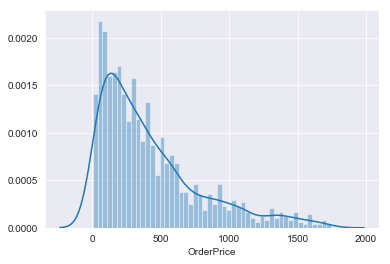

In [9]:
# Look at the distribution of prices, just in case
sns.distplot(df1.OrderPrice, bins=50);

,OrderDate,CategoryName,Units,OrderPrice
0,2012-07,Beverages,272,3182.50
1,2012-08,Beverages,347,4866.88
2,2012-09,Beverages,285,5088.40
3,2012-10,Beverages,281,4182.16
4,2012-11,Beverages,252,2616.86


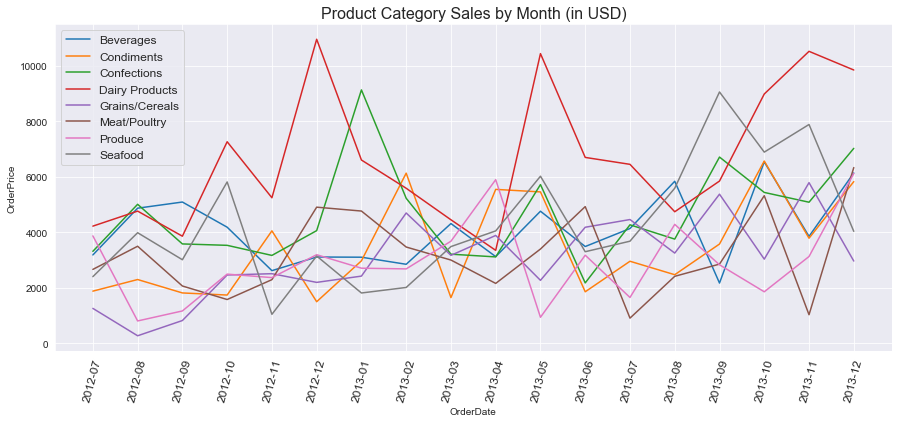

In [10]:
df2 = pd.DataFrame(df1.groupby(['OrderDate', 'CategoryName'], as_index=False).sum()
                   .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))
display(df2.head())

# Plot trends
plt.figure(figsize=(15,6))
plt.title('Product Category Sales by Month (in USD)', fontsize=16)
for i in list(df2.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=df2.loc[df2.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

### Accounting for climate differences

In [11]:
# Split data by Latitudinal climate regions
north_df = df1.loc[~df1.CustomerCountry.isin(['Mexico','Venezuela','Brazil','Argentina'])].reset_index(drop=True)
tropic_df = df1.loc[df1.CustomerCountry.isin(['Mexico','Venezuela','Brazil'])].reset_index(drop=True)
south_df = df1.loc[df1.CustomerCountry == 'Argentina'].reset_index(drop=True)

,OrderDate,CategoryName,Units,OrderPrice
0,2012-07,Beverages,204,2203.30
1,2012-08,Beverages,311,4569.68
2,2012-09,Beverages,260,4788.40
3,2012-10,Beverages,251,3750.16
4,2012-11,Beverages,184,1800.44


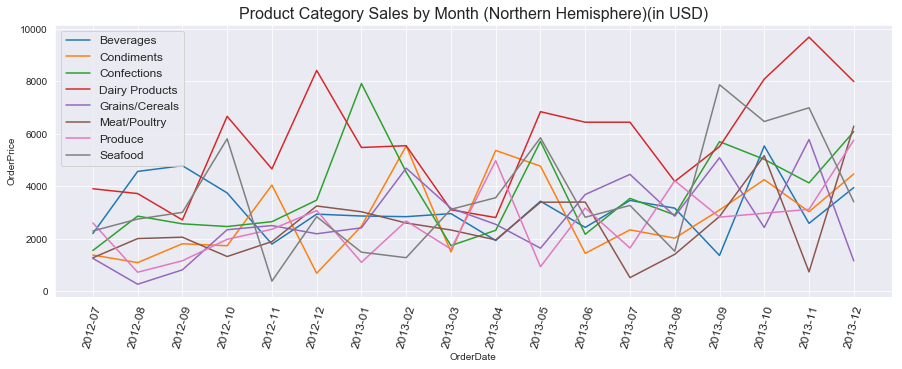

In [12]:
# Plot only Northern Hemisphere observations, in order to remove
# potentially confounding influence of regions experiencing different seasons
north_df2 = pd.DataFrame(north_df.groupby(['OrderDate', 'CategoryName'], as_index=False).sum()
                         .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))
display(north_df2.head())

# Plot trends
plt.figure(figsize=(15,5))
plt.title('Product Category Sales by Month (Northern Hemisphere)(in USD)', fontsize=16)
for i in list(north_df2.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=north_df2.loc[north_df2.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

#### Group by season

In [13]:
season_df = north_df2.copy()
# winter = ['-01','-02','-03']
# spring = ['-04','-05','-06']
# summer = ['-07','-08','-09']
# autumn = ['-10','-11','-12']
# seasons = ['Winter','Spring','Summer','Autumn']
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-01', 'aWinter'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-02', 'aWinter'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-03', 'aWinter'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-04', 'bSpring'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-05', 'bSpring'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-06', 'bSpring'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-07', 'cSummer'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-08', 'cSummer'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-09', 'cSummer'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-10', 'dAutumn'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-11', 'dAutumn'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-12', 'dAutumn'))

season_df2 = pd.DataFrame(season_df.groupby(['OrderDate', 'CategoryName'], as_index=False).sum()
                         .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))

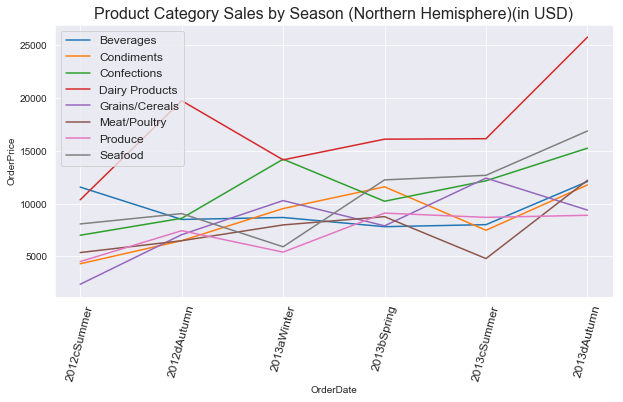

In [14]:
# Plot 
plt.figure(figsize=(10,5))
plt.title('Product Category Sales by Season (Northern Hemisphere)(in USD)', fontsize=16)
for i in list(season_df2.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=season_df2.loc[season_df2.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

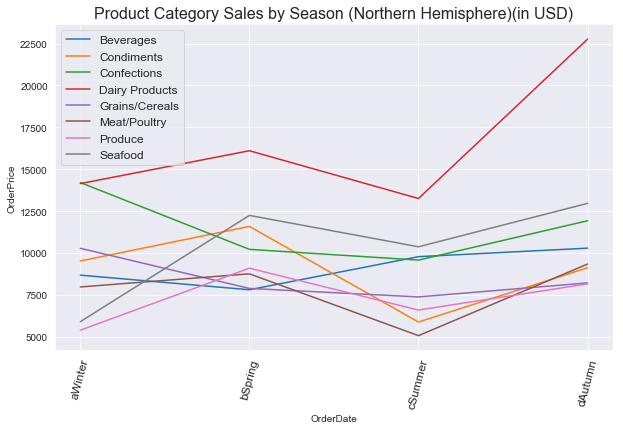

In [15]:
# Average the data by season (no longer dependent on year)
season_df3 = season_df2.copy()
season_df3.OrderDate = season_df3.OrderDate.map(lambda x: x[-7:])
season_df4 = pd.DataFrame(season_df3.groupby(['OrderDate', 'CategoryName'], as_index=False).mean()
                         .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))

# Plot, once again
plt.figure(figsize=(10,6))
plt.title('Product Category Sales by Season (Northern Hemisphere)(in USD)', fontsize=16)
for i in list(season_df4.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=season_df4.loc[season_df4.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

## Sampling Distributions

In [25]:
# define a function to create a sample distribution

def create_sample_distribution(data, dist_size=30, n=30):
    """
    Inputs:
    - data : original dataset
    - dist_size : number of samples to generate
    - n : size of each sample
    =======================
    Returns:
    - sample distribution of sample means
    """
    sample_distr = []
    np.random.seed(37)   #so tests are reproducible
    for i in range(0,dist_size):
        sample = []
        i_list = list(np.random.randint(0,len(data),n))
        for item in i_list:
            sample.append(data[item])
        sample_distr.append(np.mean(sample))
    return sample_distr

In [22]:
# Iterate making sample distributions for all season-category combinations 
seasons = []
cats = []
ord_pr = []
ordp = []
for season in list(season_df4.OrderDate.values):
    for cat in list(season_df4.CategoryName.values):
        for i in range(0,30):
            seasons.append(season)
            cats.append(cat)
        a1 = list(season_df4.OrderPrice[season_df4.OrderDate == season].values)
        a2 = create_sample_distribution(a1, 30, 30)
        ordp.append(a2)

for i in ordp:
    for e in i:
        ord_pr.append(e)

## Hypothesis Testing

In [23]:
# Make a DataFrame of all of our sampling distributions
samps = {}
samps['Season'] = seasons
samps['Category'] = cats
samps['OrderPrice'] = ord_pr
samp_distributions_df = pd.DataFrame(samps)

In [24]:
# Run OLS analysis to see if Season correlates to 
# OrderPrice for each Product Category
for i in list(samp_distributions_df.Category.unique()):
    print('\n',i,'-------------------------------')
    ols_df = samp_distributions_df.loc[samp_distributions_df.Category == i]
    formula = 'OrderPrice ~ C(Season)'
    lm = ols(formula, ols_df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(table)


 Beverages -------------------------------
                 sum_sq      df            F  PR(>F)
C(Season)  5.011200e+09     3.0  4516.193092     0.0
Residual   1.418818e+09  3836.0          NaN     NaN

 Condiments -------------------------------
                 sum_sq      df            F  PR(>F)
C(Season)  4.927755e+09     3.0  4454.359897     0.0
Residual   1.414559e+09  3836.0          NaN     NaN

 Confections -------------------------------
                 sum_sq      df            F  PR(>F)
C(Season)  5.016382e+09     3.0  4595.783521     0.0
Residual   1.395688e+09  3836.0          NaN     NaN

 Dairy Products -------------------------------
                 sum_sq      df            F  PR(>F)
C(Season)  5.290753e+09     3.0  4801.703454     0.0
Residual   1.408898e+09  3836.0          NaN     NaN

 Grains/Cereals -------------------------------
                 sum_sq      df            F  PR(>F)
C(Season)  4.939100e+09     3.0  4656.990938     0.0
Residual   1.356125e+09  

## Analysis & Recommendations

According to the OLS outputs above, we can confidently (>99.99%) reject the null hypothesis. In other words, the season of the year almost certainly influences customer demand for all of the product categories. In terms of actionable information, we can use the last graph above to make a list of the highest demand and lowest demand seasons for each category.

| **Product Category** | **Highest Demand** | **Lowest Demand** |
|------|:------:|:-------:|
| Beverages | Autumn | Spring |
| Condiments | Spring | Summer |
| Confections | Winter | Summer |
| Dairy | Autumn | Summer |
| Grains | Winter | Summer |
| Meat | Autumn | Summer |
| Produce | Spring | Winter |
| Seafood | Autumn | Winter |

Given this information, I recommend that salespersons focus on selling each product category during its respective highest demand season and spend less attention attempting to sell them during their lowest demand seasons. When demand is highest, sales of that product should be easiest to accomplish; conversely, when demand is lowest, sales will be hard fought, so it would make sense to prioritize items which are more likely to sell.